TO FORECAST POSITION 462 i LOOK INTO THE FIRST 450 REAL POSITIONS PLUS 11 FORECASTED POSITIONS   
Basically, to forecast the test set I DID all the FORECASTS on day 450

I tried it, it does not do any good, as we already knew, MA(2) only is able to forecast the first two steps.  
Regardless if both at once, or one first then another (see note below)


In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# SALES OF WIDGETS OVER 500 DAYS STARTING 2019

df = pd.read_csv('../data/widget_sales.csv')

print(df.head(), df.shape)

   widget_sales
0     50.496714
1     50.805493
2     51.477758
3     53.542228
4     54.873108 (500, 1)


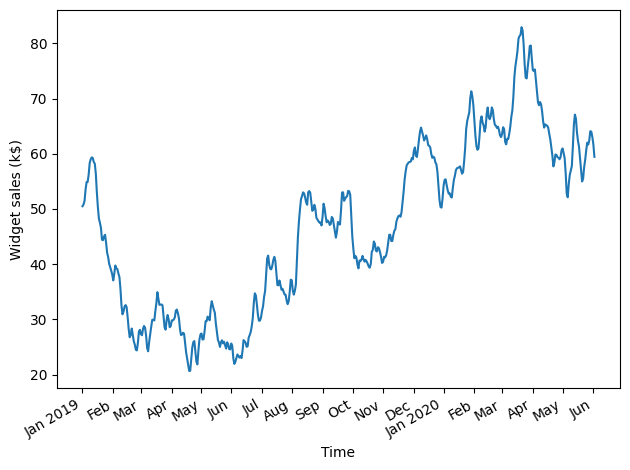

In [3]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

We are going to work with train portion of dataset only since the beginning. Later, we will forecast the test portion and measure the forecast error

In [4]:
# train = df['widget_sales'][:int(0.9*len(df['widget_sales']))]
# test = df[int(0.9*len(df['widget_sales'])):]

train = df[:int(0.9*len(df['widget_sales']))]
test = df[int(0.9*len(df['widget_sales'])):]

print(len(train), type(train), train.shape)
print(len(test),  type(test), test.shape)

450 <class 'pandas.core.frame.DataFrame'> (450, 1)
50 <class 'pandas.core.frame.DataFrame'> (50, 1)


In [5]:
ADF_result = adfuller(train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.2109796621842983
p-value: 0.6688547943380172


In [6]:
widget_sales_diff_train = np.diff(train['widget_sales'], n=1)

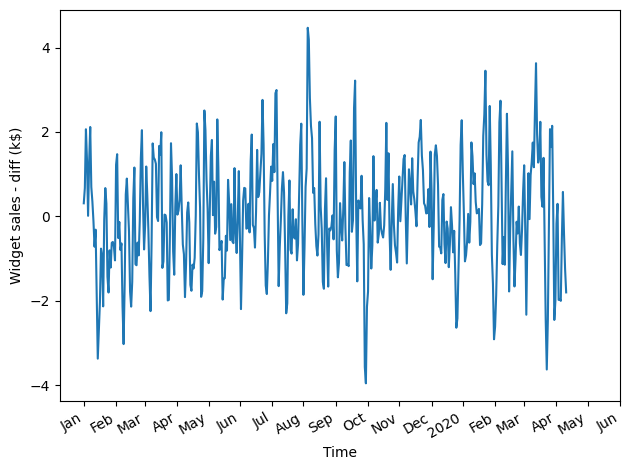

In [7]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff_train)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
ADF_result = adfuller(widget_sales_diff_train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.098597045268312
p-value: 1.0743182765603781e-17


First-order differencing makes it stationary. We could use ARIMA d=1

In [9]:
d = 1

In [10]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [12]:
result_df = optimize_ARIMA(train['widget_sales'], order_list, d) # we send the original series, not the differencing
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.431850
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643270


Here, let's use ARIMA(0,1,2). First let's take a look to the residuals

In [13]:
model = SARIMAX(train['widget_sales'], order=(0,1,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -624.205
Date:                Sun, 08 Feb 2026   AIC                           1254.409
Time:                        23:18:11   BIC                           1266.730
Sample:                             0   HQIC                          1259.266
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8627      0.048     17.904      0.000       0.768       0.957
ma.L2          0.2532      0.049      5.139      0.000       0.157       0.350
sigma2         0.9425      0.060     15.835      0.0

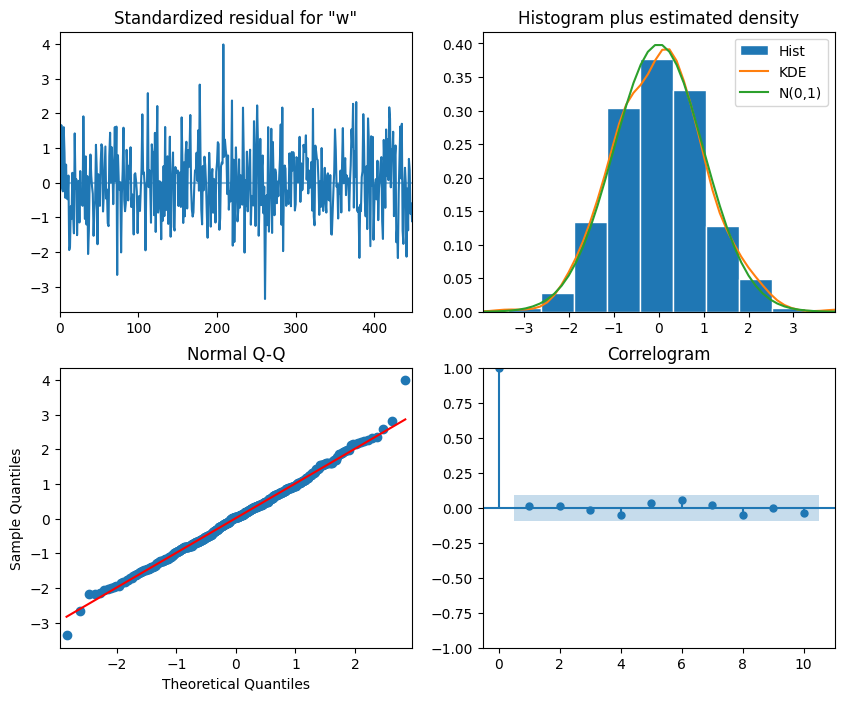

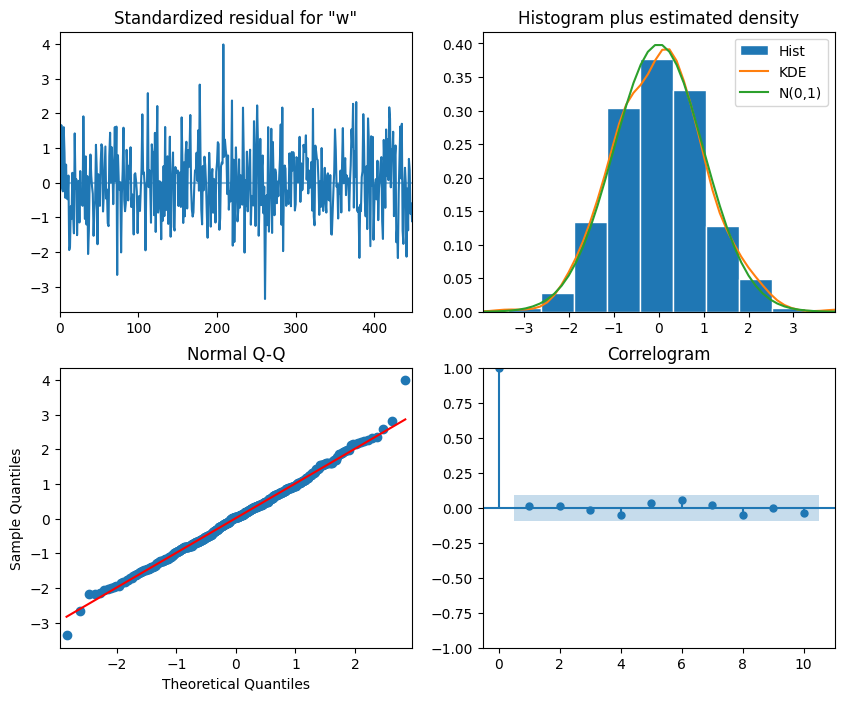

In [14]:
model_fit.plot_diagnostics(figsize=(10,8))

Residuals resemble white noise: normally distributed and uncorrelated

In [15]:
residuals = model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 21, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.018480,0.891867
2,0.062513,0.969227
3,0.343987,0.951554
4,0.394414,0.982932
5,0.394606,0.995477
6,0.922242,0.988389
7,1.047291,0.994029
8,1.148686,0.997123
9,1.176231,0.998912
10,1.254482,0.999518


Residuals are uncorrelated
### Model ready for forecast

In [16]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            for w in range(window):
                df.loc[i+w,'widget_sales'] = mean

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            for w in range(window):
                df.loc[i+w,'widget_sales'] = last_value
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,1,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(i, i + window - 1)   # changed from (0, i + window - 1) to (i, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            for w in range(window):
                df.loc[i+w,'widget_sales'] = oos_pred.iloc[0+w]
            
        return pred_MA

In [17]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2 #2

pred_mean = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(train, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARIMA'] = pred_ARIMA

pred_df.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.827303
451,65.316972,45.472231,65.906136,64.553994
452,65.172070,45.472231,65.906136,64.553995
453,65.075506,45.472231,65.906136,64.553994
454,64.703173,45.472231,65.906136,64.553995


WINDOW = 1


widget_sales	pred_mean	pred_last_value	pred_ARIMA  
450	64.736005	45.472231	65.906136	64.827303  
451	65.316972	45.472231	65.906136	64.553994  
452	65.172070	45.472231	65.906136	64.553995  
453	65.075506	45.472231	65.906136	64.553994  
454	64.703173	45.472231	65.906136	64.553994  

WINDOW = 2

widget_sales	pred_mean	pred_last_value	pred_ARIMA  
450	64.736005	45.472231	65.906136	64.827303  
451	65.316972	45.472231	65.906136	64.553994  
452	65.172070	45.472231	65.906136	64.553995  
453	65.075506	45.472231	65.906136	64.553994  
454	64.703173	45.472231	65.906136	64.553995  

As you can see, the first two ARIMA forecasts are exactly the same if we forecast them both from 450 or 1 from 450 and then another from 450+forecast_1




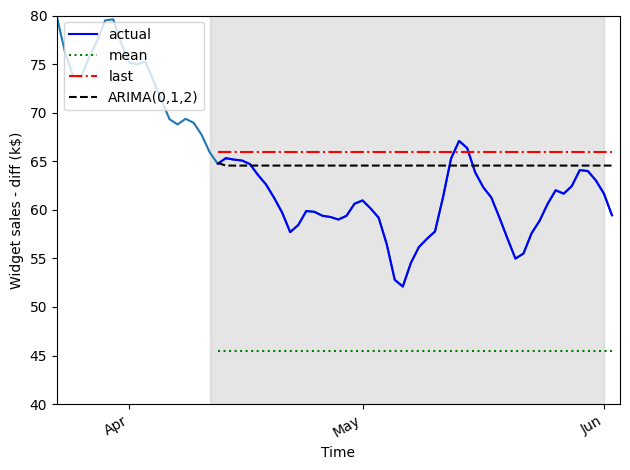

In [18]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.plot(pred_df['widget_sales'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARIMA'], 'k--', label='ARIMA(0,1,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)
ax.set_ylim(40, 80)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales'], pred_df['pred_last_value'])
mse_ARIMA = mean_squared_error(pred_df['widget_sales'], pred_df['pred_ARIMA'])

print(mse_mean, mse_last, mse_ARIMA)

236.20270668814862 41.69949493795268 28.768321617411743


In [20]:
df['pred_widget_sales'] = pred_df['pred_ARIMA']

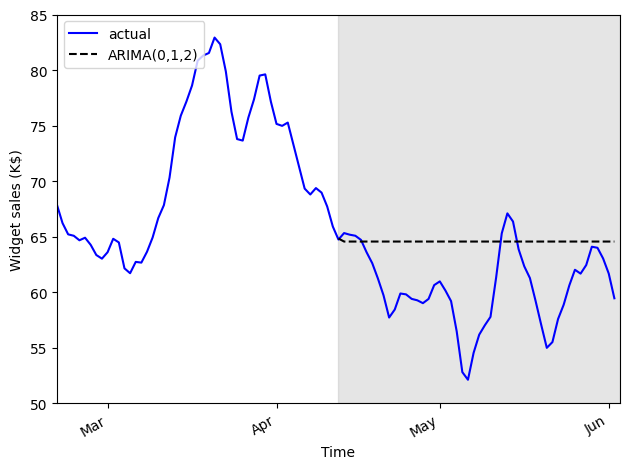

In [21]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='ARIMA(0,1,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)
ax.set_ylim(50, 85)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

4.395895709137937


In Chapter 4 using MA(2) we obtained a Mean Absolute Error of $1,535.

When using ARIMA(3,1,3) we got a MAE of $847, almost half.

Using ARIMA(0,1,2) got a MAE of $845.

Why MA(2) $1,535 and ARIMA(0,1,2) 845? (it should be the same)

We used WINDOW=1 in all of them.
